In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib; matplotlib.set_loglevel("critical")
import random

from tensorflow import keras
from tensorflow.keras import layers, models
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add
import tensorflow_addons as tfa

import warnings 
warnings.filterwarnings(action='ignore')

In [2]:
tf.random.set_seed(812)

# 평가 루브릭
[x] 프로젝트 제출   
[x] CNN 기반 딥러닝 모델 학습이 안정적으로 수렴하는 것을 시각화를 통해 확인하였다.  
[] 데이터 augmentation 기법을 사용해서 베이스 모델과의 성능을 비교.=> 증강 이미지 확인할때마다 커널 DIE    
[x] 모델 구조 변경을 통해 베이스 모델과의 성능 비교  
[] ResNet-18 모델을 구현하고 학습 성공    
[x] 보고서 양식(개요, 목차, 주석 및 의견, summary, 회고, reference 등)이 포함되어 있지 않을 경우 감점 1점

# 회고 
- 아이펠 모듈과 노드 작성자에 따라 코드 스타일이 계속 바뀌는 것에 불만이 쌓이고 있습니다. 특히 이번 노드는 필요 이상으로 복잡하게 쓰여있어서 데이터의 label 정보를 확인하는 데 애를 많이 먹었습니다. 작성자께서 참고하셨다던 Kaggle 노트가 차라리 이해하기 쉬웠던 것 같아요. 가장 불편하고 당혹스러운 점은 학습 또는 퀘스트 대부분의 시간을 생소한 남의 코드를 읽고 해석하는데 쓰게된다는 점이고, 남이 짜놓은 코드 틀에 맞추려다보니 입문자 입장에서는 쉽게 다른 방식을 적용하거나 목적에 맞게 실험하지 못한다는 것입니다. 노드를 따라가는 과정이 개인적으로는 오히려 습득에 방해가 되고 있어서 어떤 식으로 공부를 이어가야할 지 고민이 많이됩니다.   


- 커널이 자주 죽다보니 모델을 저장하고 불러오는 과정에 약간의 공부가 되었다. 시각화, 예측등 불러온 모델로 다른 실험을 이어가려면 모델 외에 변수파일도 따로 저장해주어야 한다는 점 (pickle, json등의 방법이 있고, 딕셔너리 형태를 불러올 때는 json이 적합하다는 것). 코드블럭의 순서가 엉키거나 제대로 변수명을 업데이트 해주지 않아서 정작 모델을 불러와놓고도 엉뚱한 결과를 출력할 수 있다는 점은 유의해야겠다.  


- 그래프를 분석하(려고 노력은해보면서) 평가 metric 에 대해 다시 복습하는 계기가 되었다. precision / accuracy / recall 의 차이에 대해서 리마인드가 되었음  


- 이번 퀘스트의 경우 데이터가 어떤식으로 담겨있는지 정확히 이해하지 못해 난관을 겪었다.   
경로변수를 설정하고 처음보는 메소드나 모듈을 사용하는등 과정부터가 낯설었다. 어찌저찌 이해한 것 같다쳐도 막상 문제를 해결하기 위해 내가 데이터를 꺼내 만져봐야하는 상황이 왔을 때 이 부분이 큰 걸림돌이 되었음  


- 퀘스트의 범위나 요구사항이 초보자가 하루동안 끝내기에 많다고 느낀다. 평가기준은 좀 낮추어서 필요조건은 시간안에 맞출 수 있게 하고, 개인이 자기 방식으로 탐색하고 결과를 도출하는 여유시간이 있으면 실력을 향상시키는 데 더 도움이 될 것 같다. 마음이 급하면 차분히 생각하기보다 얼른 꼼수라도 쓰고싶어지는 것이 사람 마음인지라   

## 목차

# CNN

## 데이터 전처리

### 데이터 로드 및 균형 잡기

In [3]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 10

print(ROOT_PATH)

/aiffel/aiffel


Test, Train, Val 데이터셋으로 나뉘고, 각각의 폴더에 Normal과 Pneumonia 가 분류되어있는 데이터셋

In [4]:
# 데이터 개수 확인
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(f"train data: {len(train_filenames)}")
print(f"test data: {len(test_filenames)}")
print(f"validation data: {len(val_filenames)}")

train data: 5216
test data: 624
validation data: 16


val 데이터 수가 너무 적어서 train과 val을 합친 후 80:20으로 분할

In [5]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(f"train data: {len(train_filenames)}")
print(f"validation data: {len(val_filenames)}")

train data: 4185
validation data: 1047


In [6]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0450-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1345_bacteria_3422.jpeg


In [7]:
# 파일 경로에 NORMAL 이 있는가를 기준으로 정상 이미지와 폐렴 이미지 데이터를 식별한다.
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


클래스 불균형(imbalance)가 관찰됨: 정상보다 폐렴 이미지 수가 3배 더 많다.  
- test와 validation 셋은 평가용이므로 불균형한 데이터셋이 문제되지 않음
- train data만 균형을 조정할 필요가 있어보인다.

In [8]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [9]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


### 함수 정의

파일 경로에 'NORMAL'이나 'PNEUMONIA'가 포함되어 있기 때문에 이를 이용해서 라벨 데이터를 만들어 주는 함수를 만들어 본다.

In [10]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

이미지의 사이즈를 통일 시키고 GPU 메모리를 더욱 효율적으로 사용하기 위해 이미지 사이즈를 줄인다. decode_img 함수와 process_path 함수를 만들어보자.

In [11]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

AUTOTUNE변수를 활용해 빠르게 데이터 처리
훈련용, 검증용 데이터셋을 분리한다. 

In [12]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [13]:
# 이미지 처리가 잘되었는지 리사이즈, 라벨링 결과 확인
for image, label in train_ds.take(7): #하나의 데이터만 호출
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False
Image shape:  (180, 180, 3)
Label:  True
Image shape:  (180, 180, 3)
Label:  True
Image shape:  (180, 180, 3)
Label:  True
Image shape:  (180, 180, 3)
Label:  False
Image shape:  (180, 180, 3)
Label:  True
Image shape:  (180, 180, 3)
Label:  False


In [14]:
# 테스트 데이터 생성
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [15]:
# tf.data 파이프라인을 사용해 효율적인 학습 데이터 사용
def prepare_for_training(ds, shuffle_buffer_size=1000):
    # 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    # 에포크 진행시 데이터셋을 재사용할 수 있게 자동으로 데이터를 맞춰줌
    ds = ds.repeat()
    # BATCH_SIZE에서 정한 만큼의 배치 생성
    ds = ds.batch(BATCH_SIZE)
    # 학습데이터를 나눠서 읽어오는 방식으로 gpu 리소스의 유휴 상태를 줄인다.
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

### 데이터 시각화

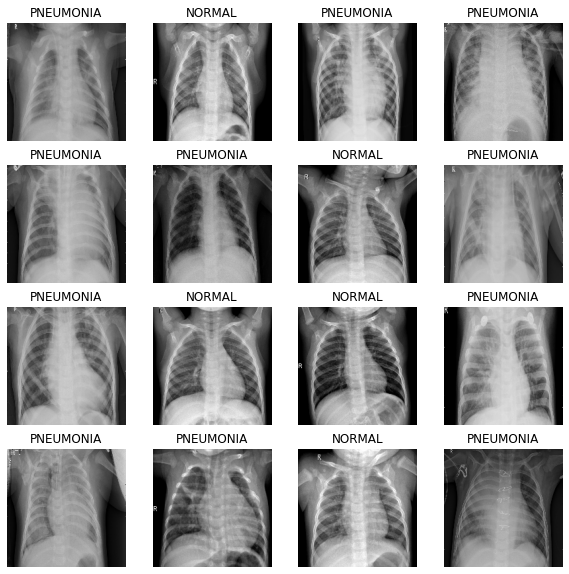

In [16]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

2열 2행 이미지는 PNEUMONIA 가 아니라 NORMAL 아닌가?
정답지가 잘못됐을 가능성은?
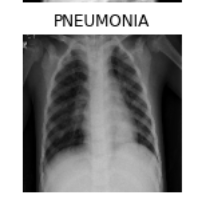

## CNN 모델링

In [17]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        # batch normalization으로 얻는 효과: gradient vanishing, gradient exploding 해결
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [18]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

우리가 만들 CNN 모델은 약간의 수정을 거쳐 만들어진 모델입니다. 전형적인 CNN 모델과는 약간 다른 모델입니다.

어떤 부분이 가장 특이한가요? 눈에 띄셨을지 모르겠지만, 방금 만들어진 모델에는 Batch Normalization과 Dropout이라는 두 가지 regularization 기법이 동시에 사용되고 있습니다.
일반적으로 이런 방법은 잘 사용되지 않거나, 금기시되기도 합니다. 대표적으로 아래와 같은 논문의 사례를 들 수 있습니다.

- Understanding the Disharmony between Dropout and Batch Normalization by Variance Shift  

위 논문에서는 variance shift를 억제하는 Batch Normalization과 이를 유발하는 Dropout을 동시에 사용하는 것이 어울리지 않는다고 밝히고 있습니다.

그러나, 실용적으로는 두 방법을 같이 쓰는 것이 낫다고 보는 견해도 없는 것은 아닙니다. 예외적으로 동시에 사용하는 것이 성능 향상에 도움을 주는 경우가 실제로 있습니다. 아래 논문과 같이 두 방법을 같이 쓰는 것을 옹호하는 경우도 있습니다.

- Rethinking the Usage of Batch Normalization and Dropout in the Training of Deep Neural Networks  

이번 실습에서는 두 가지를 함께 사용하는 이 모델이 성능 향상에 도움이 될지 여부도 흥미롭게 살펴볼만 한 부분입니다.

In [19]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

#### 데이터 imbalance 처리

한 라벨이 너무 많은 경우를 imbalance 하다고 하는데, 데이터를 학습할 때 imbalance한 데이터의 경우 학습 효과가 좋지 않을 수 있습니다.

이런 문제들을 해결하는 방법으로 *Weight balancing*이라는 테크닉이 사용됩니다. Weight balancing 은 training set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법입니다. Keras는 model.fit()을 호출할 때 파라미터로 넘기는 class_weight 에 이러한 클래스별 가중치를 세팅할 수 있도록 지원하고 있습니다. 상세한 내용은 아래 링크를 참고합시다.

In [20]:
# Normal 이미지에 사용할 weight 세팅  => 전체 데이터 건수에 반비례하게 설정
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
# Pneumonia 이미지에 사용할 weight 세팅 => 전체 데이터 건수에 반비례하게 설정
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


## 모델 훈련

In [21]:
# 컴파일
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [23]:
# 핏
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 66s 202ms/step - loss: 0.0816 - accuracy: 0.9722 - precision: 0.9921 - recall: 0.9704 - val_loss: 0.0543 - val_accuracy: 0.9788 - val_precision: 0.9856 - val_recall: 0.9856
Epoch 2/10
261/261 [==============================] - 52s 199ms/step - loss: 0.0800 - accuracy: 0.9717 - precision: 0.9927 - recall: 0.9691 - val_loss: 0.0976 - val_accuracy: 0.9644 - val_precision: 0.9946 - val_recall: 0.9567
Epoch 3/10
261/261 [==============================] - 52s 200ms/step - loss: 0.0757 - accuracy: 0.9732 - precision: 0.9931 - recall: 0.9707 - val_loss: 0.0563 - val_accuracy: 0.9788 - val_precision: 0.9894 - val_recall: 0.9817
Epoch 4/10
261/261 [==============================] - 53s 203ms/step - loss: 0.0736 - accuracy: 0.9727 - precision: 0.9941 - recall: 0.9692 - val_loss: 0.1910 - val_accuracy: 0.9394 - val_precision: 0.9237 - val_recall: 1.0000
Epoch 5/10
261/261 [==============================] - 54s 207ms/step - loss: 0.0579 - accura

### 모델 저장

In [37]:
# 모델 저장
model.save('models/saved_model_v1/', save_format='tf')

# 히스토리 파일 저장
import json

with open('model_history.json', 'w') as f:
    json.dump(history.history, f)

INFO:tensorflow:Assets written to: models/saved_model_v1/assets


In [38]:
import os

# 저장한 경로 설정
save_dir = 'models/'

# 해당 디렉터리에 있는 파일 및 폴더 출력
print("저장된 파일 목록:", os.listdir(save_dir))


저장된 파일 목록: ['saved_model_v1']


### 모델 불러오기

In [25]:
# 모델 불러오기
model = keras.models.load_model('models/saved_model_v1/')

# 히스토리 불러오기
import json

with open('model_history.json') as f:
    history = json.load(f)

## 결과 확인

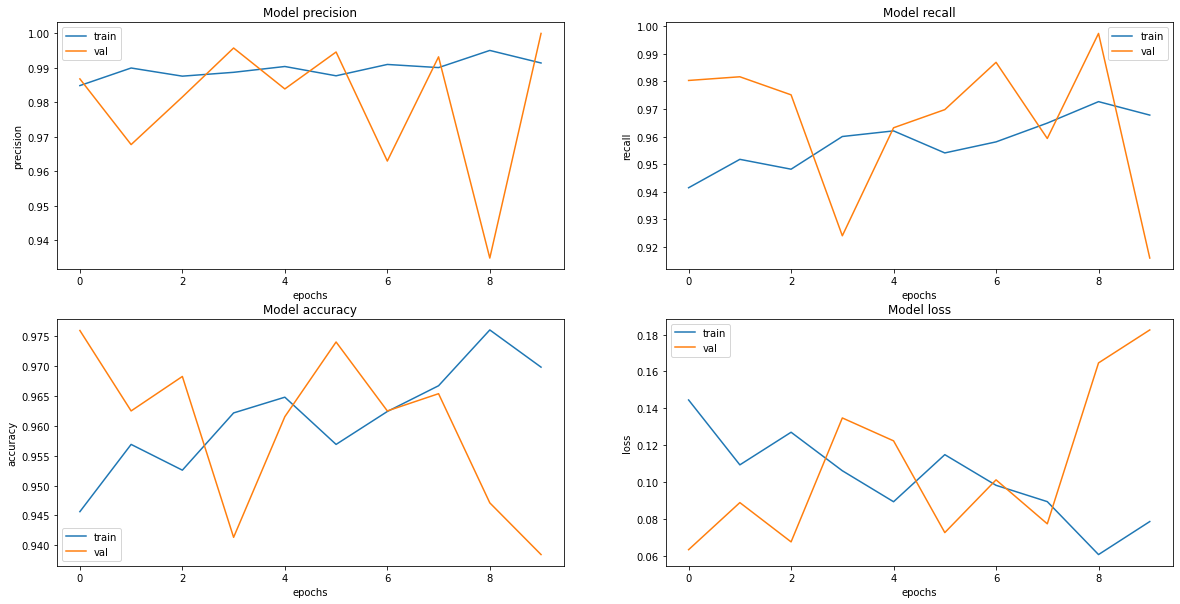

In [40]:
# 에포크마다 모델의 precision, recall, accuracy, loss 가 어떻게 변하는지 확인
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

# Ablation Study 성능 평가 비교

#### 1차 훈련 결과 (10 epochs)
Epoch 10/10  
val_loss: 0.1409  
val_accuracy: 0.9462 
val_precision: 0.9326  
val_recall: 0.9987  

결과: 테스트 데이터의 정확도는 is 0.7.val_accuracy 보다 낮고 오버피팅 가능성 있음.
recall 이 precision 보다 높아서 대부분의 pneumonia 양성 이미지를 잘 찾아냈지만 몇 몇의 음성이미지도 잘못 분류되었음

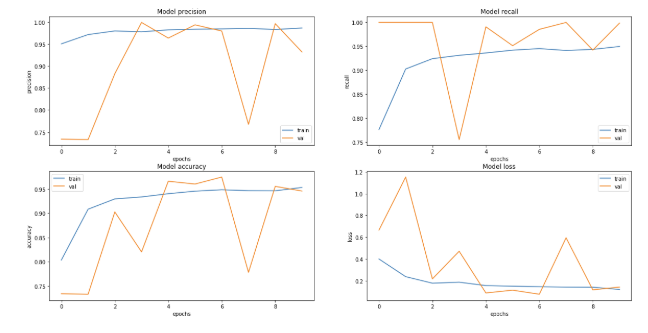

#### 2차 훈련 결과 (finetuned-learning rate scheduler )
Epoch 10/10 
val_loss: 0.1928  
val_accuracy: 0.9173  
val_precision: 0.9942  
val_recall: 0.8928  
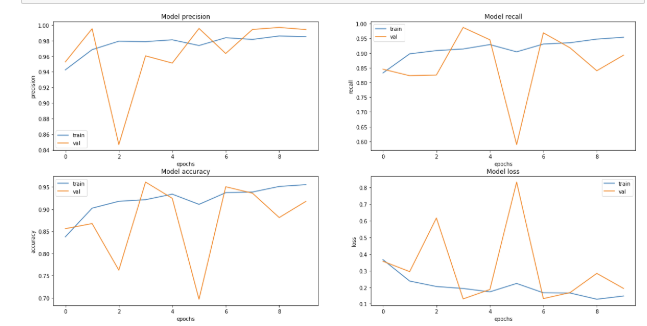

#### 커널 리셋 후 재시도: 1차 훈련 결과 (10 epochs)
Epoch 10/10   
val_loss: 0.1825  
val_accuracy: 0.9385  
val_precision: 1.0000  
val_recall: 0.9160  

결과: 아무것도 바꾸지 않고 훈련만 재시작했는데 precision: 1 이 나와서 의아함
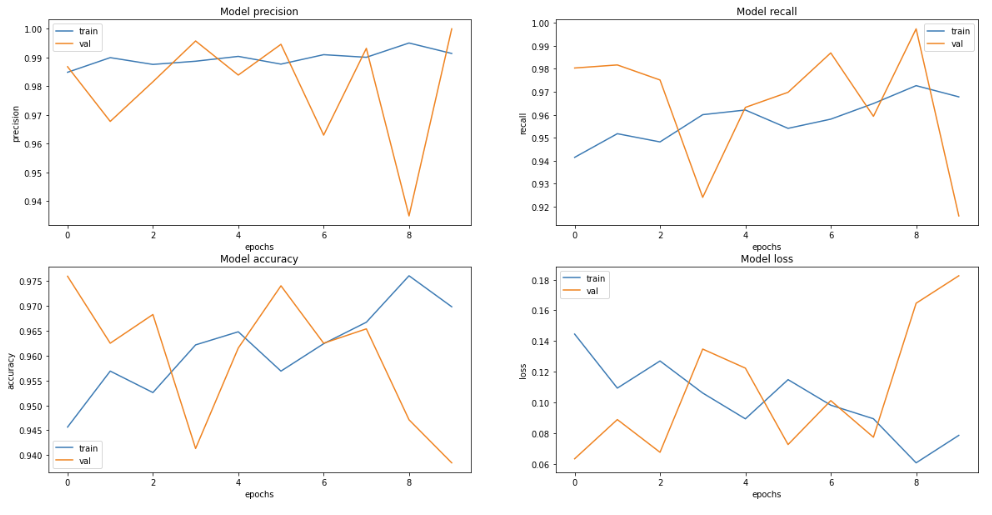

#### 커널 리셋 후 재시도: 2차 훈련 결과 (finetuned-learning rate scheduler)
Epoch 20/20  
val_loss: 0.0920  
val_accuracy: 0.9692  
val_precision: 0.9906  
val_recall: 0.9672  

결과: 프리시전은 여전히 1에 수렴하는데 정확도와 리콜이 상승했고, 손실은 더 낮아졌다.
전반적으로 검증 그래프가 훈련 그래프를 비슷하게 따라가고 있음.    
의료 데이터는 양성을 놓치면 치명적이기 때문에 precision보다 recall metric을 더 중점적으로 보는데 둘 다 같은 값이 나왔다. 
결과가 너무 이상적이라서 혹시 훈련 중 데이터가 새지는 않았는지 우려됨.  
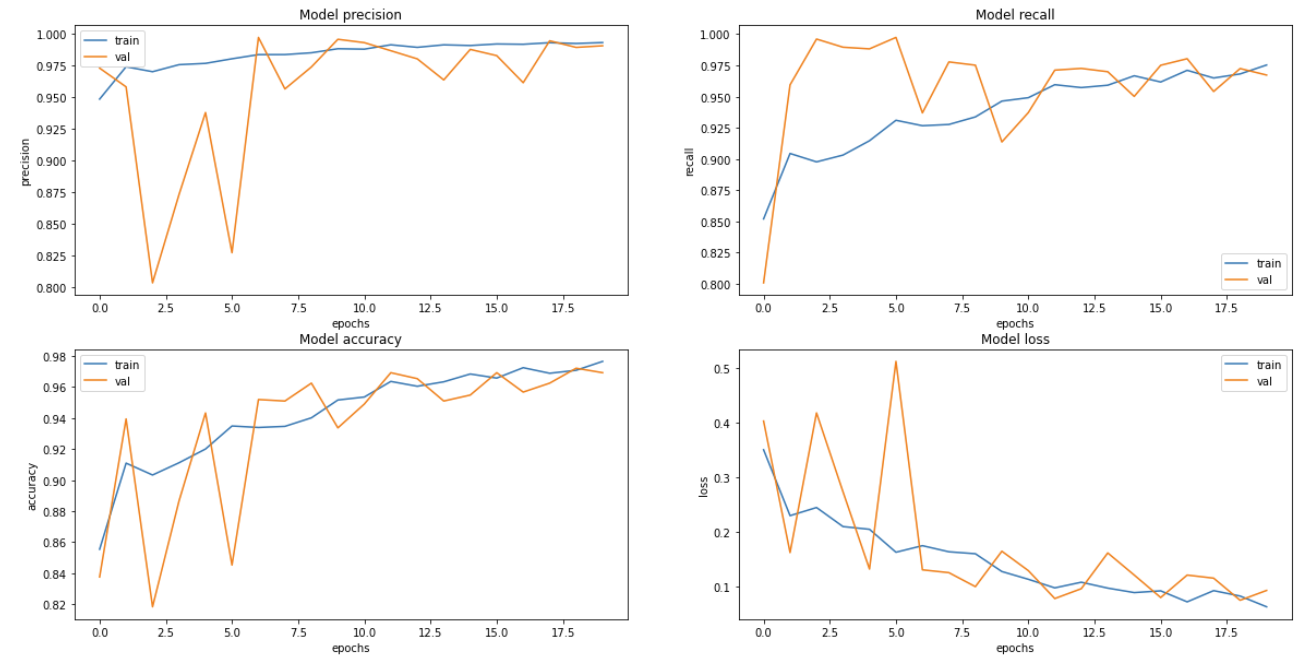

#### 3차 훈련 결과 (commented out batch-normalization and dropout)
Epoch 20/20 + 10/10
val_loss: 0.0584  
val_accuracy: 0.9760  
val_precision: 0.9842  
val_recall: 0.9829  

결과: 손실이 더 낮아지고 모든 메트릭이 상향함. 과적합을 유도했으나 early-stopping이 가동하지 않고 계속 더 나은 방향으로 학습이 진행됨.
더이상 iteration 할 필요성은 없어보이지만 이미지 증강까지만 시도해보고자 함
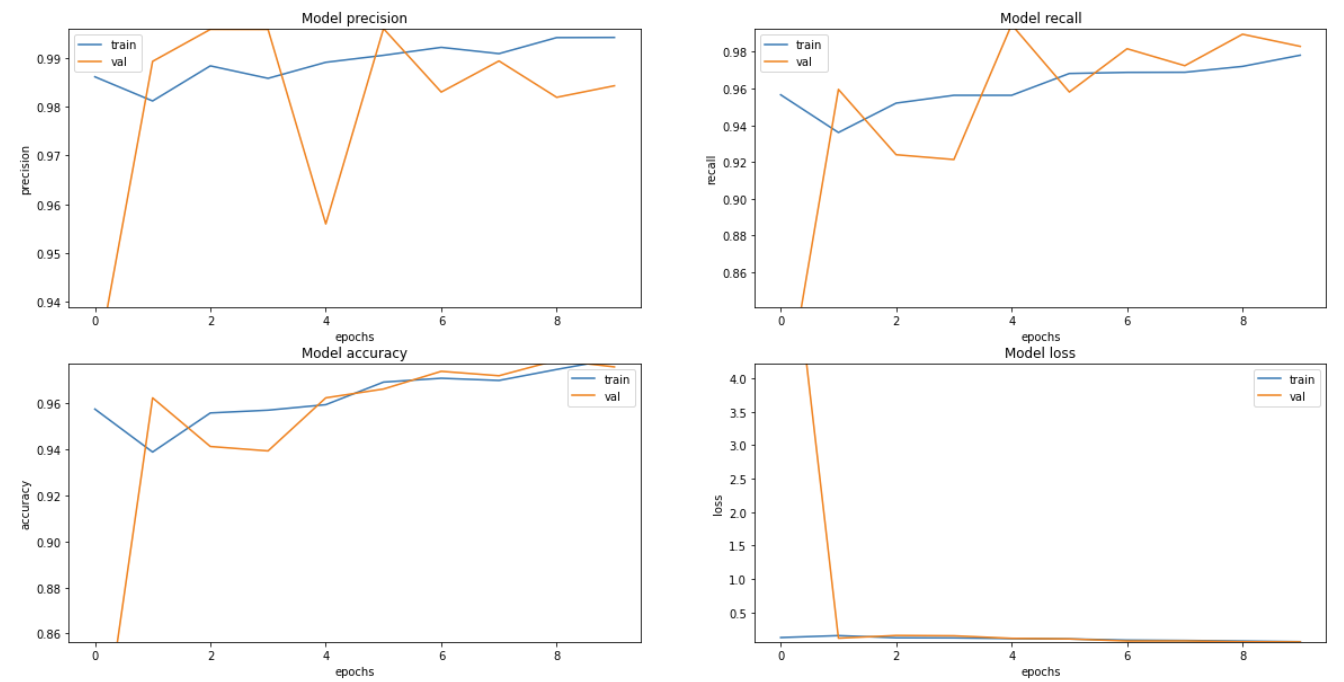

### 01. recall 값을 높이기 위한 시도

### 케라스 콜백

In [30]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("best_model.h5",
                                                 save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

### 파인튜닝 러닝레이트: Exponential learning rate scheduling method

In [31]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return float(lr0 * 0.1 **(epoch/s)) # Convert to Python float
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [43]:
# 핏
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=20,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler]
    )

Epoch 1/20
261/261 [==============================] - 60s 199ms/step - loss: 0.3501 - accuracy: 0.8554 - precision: 0.9484 - recall: 0.8520 - val_loss: 0.4028 - val_accuracy: 0.8375 - val_precision: 0.9729 - val_recall: 0.8008
Epoch 2/20
261/261 [==============================] - 52s 201ms/step - loss: 0.2292 - accuracy: 0.9109 - precision: 0.9740 - recall: 0.9044 - val_loss: 0.1615 - val_accuracy: 0.9394 - val_precision: 0.9581 - val_recall: 0.9594
Epoch 3/20
261/261 [==============================] - 51s 197ms/step - loss: 0.2441 - accuracy: 0.9033 - precision: 0.9701 - recall: 0.8977 - val_loss: 0.4178 - val_accuracy: 0.8183 - val_precision: 0.8032 - val_recall: 0.9961
Epoch 4/20
261/261 [==============================] - 51s 197ms/step - loss: 0.2092 - accuracy: 0.9112 - precision: 0.9757 - recall: 0.9031 - val_loss: 0.2729 - val_accuracy: 0.8865 - val_precision: 0.8730 - val_recall: 0.9895
Epoch 5/20
261/261 [==============================] - 53s 202ms/step - loss: 0.2042 - accura

In [45]:
# lr change 모델 저장
model.save('models/saved_model_v2_lrchange/', save_format='tf')

# # 히스토리 파일 저장
# import json

# with open('model_history_v2.json', 'w') as f:
#     json.dump(history.history, f)

INFO:tensorflow:Assets written to: models/saved_model_v2_lrchange/assets


In [2]:
import os

# 저장한 경로 설정
save_dir = 'models/'

# 해당 디렉터리에 있는 파일 및 폴더 출력
print("저장된 파일 목록:", os.listdir(save_dir))

저장된 파일 목록: ['saved_model_v2_lrchange', 'saved_model_v1']


In [26]:
# 모델 불러오기
model = keras.models.load_model('models/saved_model_v2_lrchange/')

# 히스토리 불러오기
with open('model_history.json') as f:
    history = json.load(f)

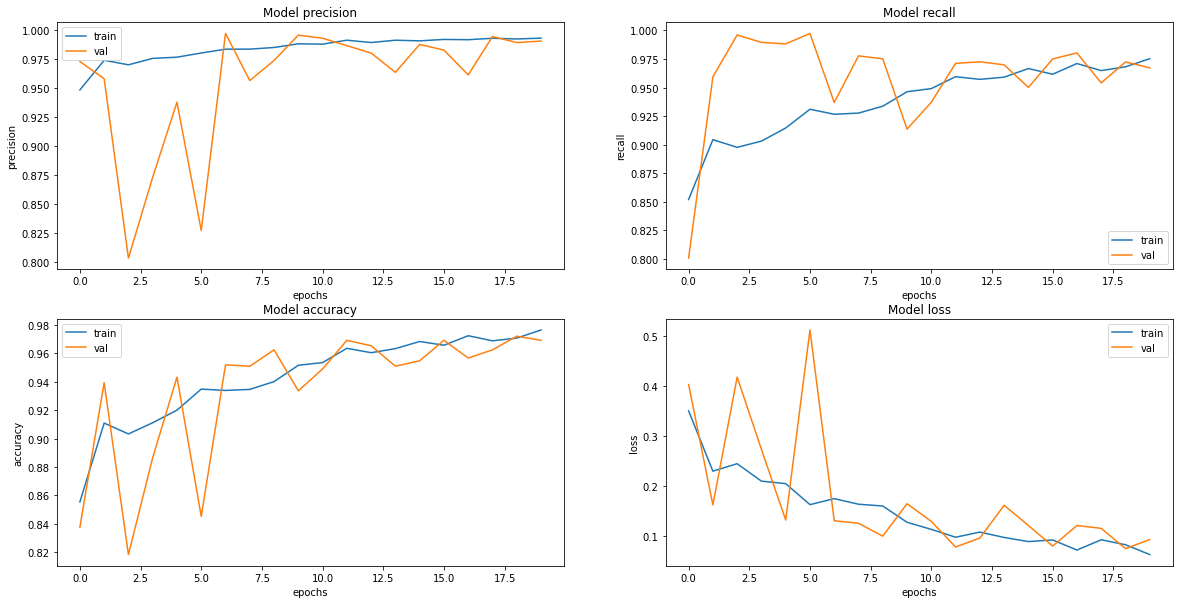

In [46]:
# 에포크마다 모델의 precision, recall, accuracy, loss 가 어떻게 변하는지 확인
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

###  02. Batch Normalization과 Dropout을 동시에 사용하지 않았을 때

In [32]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        # batch normalization으로 얻는 효과: gradient vanishing, gradient exploding 해결
#         tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

def dense_block(units):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu')
#         tf.keras.layers.BatchNormalization(),
#         tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [33]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
#         tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
#         tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [46]:
# 핏
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=10,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
#         class_weight=class_weight,
        callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler]
    )

Epoch 1/10
261/261 [==============================] - 61s 199ms/step - loss: 0.0879 - accuracy: 0.9693 - precision: 0.9819 - recall: 0.9768 - val_loss: 0.0945 - val_accuracy: 0.9731 - val_precision: 0.9718 - val_recall: 0.9921
Epoch 2/10
261/261 [==============================] - 52s 199ms/step - loss: 0.0822 - accuracy: 0.9734 - precision: 0.9820 - recall: 0.9823 - val_loss: 12.8503 - val_accuracy: 0.7288 - val_precision: 0.7321 - val_recall: 0.9934
Epoch 3/10
261/261 [==============================] - 52s 201ms/step - loss: 0.0830 - accuracy: 0.9727 - precision: 0.9838 - recall: 0.9794 - val_loss: 2.4617 - val_accuracy: 0.7038 - val_precision: 0.7291 - val_recall: 0.9489
Epoch 4/10
261/261 [==============================] - 53s 204ms/step - loss: 0.0940 - accuracy: 0.9720 - precision: 0.9832 - recall: 0.9791 - val_loss: 0.1583 - val_accuracy: 0.9442 - val_precision: 0.9316 - val_recall: 0.9974
Epoch 5/10
261/261 [==============================] - 53s 203ms/step - loss: 0.1078 - accur

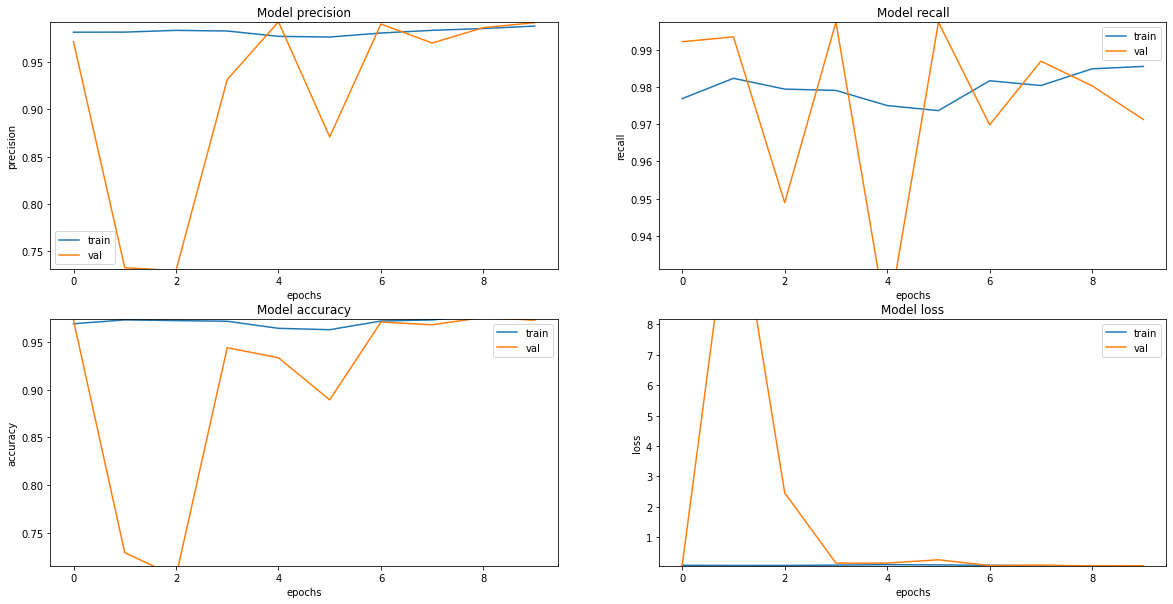

In [47]:
# 에포크마다 모델의 precision, recall, accuracy, loss 가 어떻게 변하는지 확인
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].set_ylim(np.quantile(history.history['val_'+ met],0.05),np.quantile(history.history['val_'+ met],0.95))
    ax[i].legend(['train', 'val'])

In [44]:
# lr change 모델 저장
model.save('models/saved_model_v3_sans_dr_nom/', save_format='tf')

# # 히스토리 파일 저장
# import json

# with open('model_history_v3_sans_dr_nom.json', 'w') as f:
#     json.dump(history.history, f)

INFO:tensorflow:Assets written to: models/saved_model_v3_sans_dr_nom/assets


In [45]:
import os

# 저장한 경로 설정
save_dir = 'models/'

# 해당 디렉터리에 있는 파일 및 폴더 출력
print("저장된 파일 목록:", os.listdir(save_dir))

저장된 파일 목록: ['saved_model_v2_lrchange', 'saved_model_v1', 'saved_model_v3_sans_dr_nom']


In [49]:
# 모델 불러오기
model = keras.models.load_model('models/saved_model_v3_sans_dr_nom/')

# 히스토리 불러오기
# with open('model_history_v3_sans_dr_nom.json') as f:
#     history = json.load(f)

### 03. class_weight을 생략했을 경우
실습 코드에서 데이터의 imbalance 문제에 대처하기 위해 데이터 비율로 나누어진 class_weight를 설정해 주었습니다.  
만약 이러한 처리를 생략한다면 어떻게 될까요?

Epoch 10/10
val_loss: 0.0731 - val_accuracy: 0.9731 - val_precision: 0.9920 - val_recall: 0.9712

결과: precision은 올라갔지만 recall이 하락하고 loss값이 올라간 것으로 보면 양성 클래스를 놓치는 비율이 증가했다.(애매한 경우는 부정 클래스로 예측하는 경우가 발생=> FN 증가 == Recall의 감소) class_weight 해제의 결과로 손실 함수가 다시 데이터의 불균형한 분포에 의존하게 되고 이는 모델이 소수 클래스를 예측하는 것을 주저하고, 다수 클래스를 더 자주 예측할 가능성이 높아진다. (=> 이 경우 precision값이 올라가는 것이 설명됨)
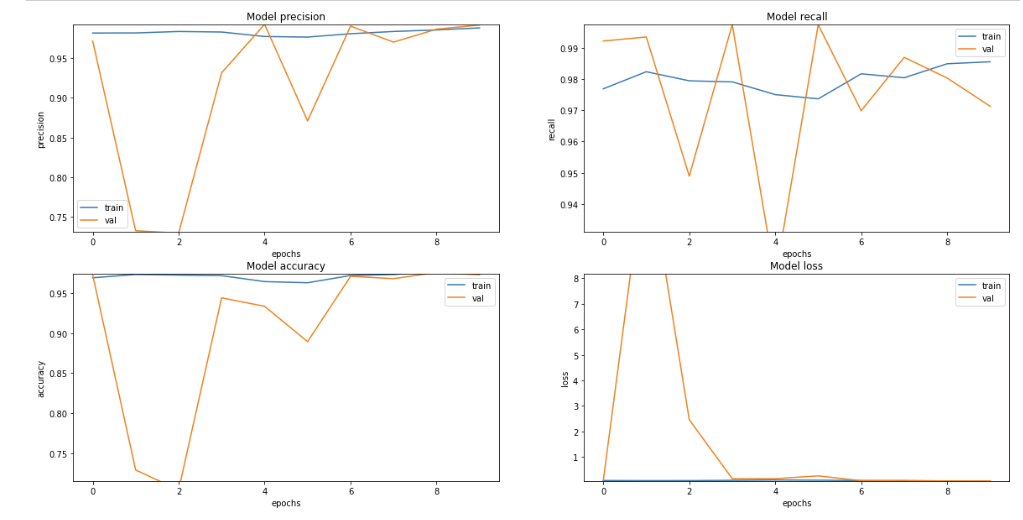              

### 02. 데이터 증강

In [77]:
print("\nBefore Augmentation:")
for image, label in train_ds.take(1):
    print(image.numpy().shape, label.numpy())


Before Augmentation:
(16, 180, 180, 3) [ True  True  True  True  True False  True  True  True  True  True  True
 False  True False  True]


In [78]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

In [ ]:
for img, label in train_ds.take(1):
    print(label)

In [3]:
print("\nAfter Augmentation:")
for image, label in train_ds.take(1):
    print(image.numpy().shape, label.numpy())


After Augmentation:


NameError: name 'train_ds' is not defined

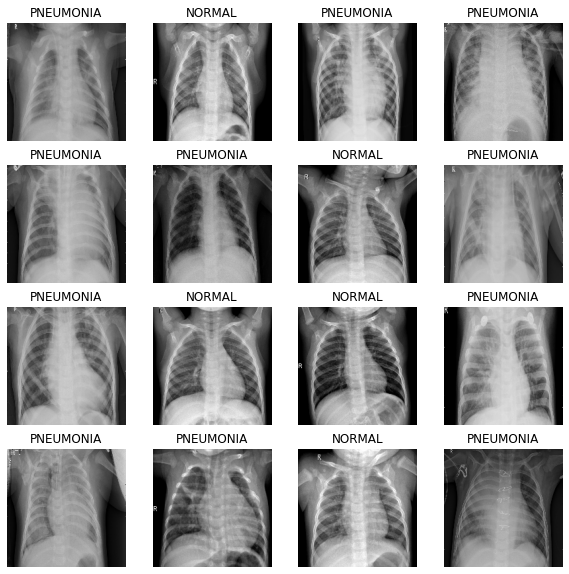

In [16]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

## 테스트 데이터로 모델 평가

In [50]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 112ms/step - loss: 0.9559 - accuracy: 0.7660 - precision: 0.7285 - recall: 0.9974
Loss: 0.9559094309806824,
Accuracy: 0.7660256624221802,
Precision: 0.7284644246101379,
Recall: 0.9974358677864075


In [53]:
predicted = model.predict(test_ds).ravel()

(array([ 20.,   8.,  10.,   4.,   4.,   4.,   3.,   1.,   2.,   1.,   3.,
          2.,   0.,   0.,   1.,   2.,   1.,   0.,   1.,   1.,   0.,   1.,
          0.,   1.,   0.,   0.,   1.,   0.,   1.,   1.,   0.,   4.,   0.,
          1.,   0.,   3.,   0.,   1.,   0.,   1.,   0.,   0.,   1.,   1.,
          0.,   2.,   0.,   0.,   1.,   2.,   0.,   1.,   0.,   0.,   4.,
          2.,   0.,   0.,   2.,   1.,   0.,   2.,   0.,   2.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   1.,   1.,   1.,   1.,   0.,   0.,
          3.,   2.,   1.,   1.,   1.,   2.,   0.,   3.,   0.,   2.,   1.,
          2.,   2.,   4.,   3.,   7.,   6.,   7.,   5.,   4.,  13.,  24.,
        422.]),
 array([7.3745119e-05, 1.0073008e-02, 2.0072270e-02, 3.0071532e-02,
        4.0070795e-02, 5.0070059e-02, 6.0069319e-02, 7.0068583e-02,
        8.0067843e-02, 9.0067111e-02, 1.0006637e-01, 1.1006563e-01,
        1.2006490e-01, 1.3006416e-01, 1.4006342e-01, 1.5006268e-01,
        1.6006194e-01, 1.7006122e-01, 1.800604

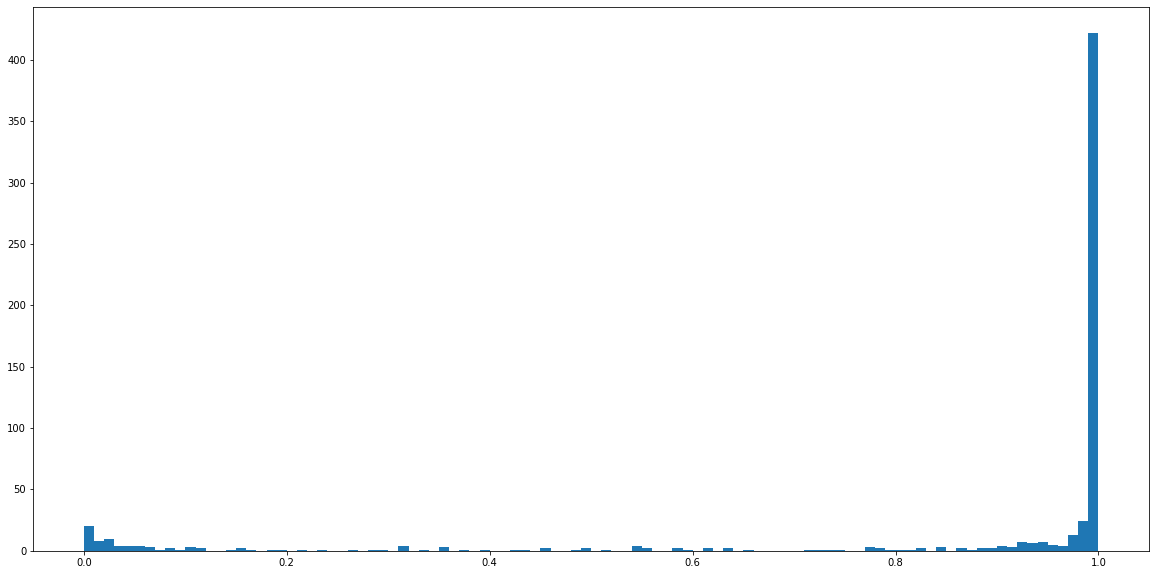

In [55]:
fig, ax = plt.subplots(figsize=(20,10))
ax.hist(predicted, bins=100)

In [ ]:
# 에포크마다 모델의 precision, recall, accuracy, loss 가 어떻게 변하는지 확인
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].set_ylim(np.quantile(history.history['val_'+ met],0.05),np.quantile(history.history['val_'+ met],0.95))
    ax[i].legend(['train', 'val'])

# ResNet 모델 구현 - 1차

In [ ]:
def build_resnet18():
    inputs = tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    
    # Initial Conv1
    x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x) # 데이터 분포 정규화
    x = tf.keras.layers.Activation('relu')(x)
    
    # MaxPool
    x = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    # Residual Blocks (Conv2 ~ Conv5)
    '''
    두 개 블록씩 구성, 모델 내 residual block 연산이 들어갈 부분에 배치 
    residual_block() 함수 호출 레이어로 각 residual block의 필터수와 스트라이드를 다르게 설정해서 다양한 특성 추출 및 크기 축소
    '''
    x = residual_block(x, filters=64,  blocks=2, stride=1) 
    x = residual_block(x, filters=128, blocks=2, stride=2)
    x = residual_block(x, filters=256, blocks=2, stride=2)
    x = residual_block(x, filters=512, blocks=2, stride=2)

    # Global Average Pooling 
    x = tf.keras.layers.GlobalAveragePooling2D()(x) # Flatten 대신 과적합 방지
    
    # FC layer
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x) 
    
    model = models.Model(inputs, x, name='resnet18_model') # 모델 객체 생성 및 반환
    return model

def residual_block(x, filters, blocks, stride): # 재사용 함수, 동일 구조의 블록을 반복 생성
    for block in range(blocks): # blocks=2: 블록 2번 연결
        x = residual_block_unit(x, filters, stride if block == 0 else 1) # 첫번째 블록에만 스트라이드 적용 후 크기 유지
    return x

def residual_block_unit(x, filters, stride): # 연산 함수
    y = tf.keras.layers.Conv2D(filters, kernel_size=3, strides=stride, padding='same')(x)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.Activation('relu')(y)
    
    y = tf.keras.layers.Conv2D(filters, kernel_size=3, strides=1, padding='same')(y)
    y = tf.keras.layers.BatchNormalization()(y)
    
    # Skip connection
    if stride > 1: # skip connection 실행 전 x와 y의 크기를 맞추기 위해 1x1 Conv 추가
        x = tf.keras.layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same')(x)
    out = tf.keras.layers.Add()([x, y])
    out = tf.keras.layers.Activation('relu')(out)
    return out

In [ ]:
# 모델 재정의 후 컴파일
with tf.device('/GPU:0'):
    model = build_resnet18()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [ ]:
# 체크포인트 생성
checkpoint = ModelCheckpoint(filepath='models/saved_model_v2_ResNet18', 
                             monitor='val_accuracy', # val_accuracy 추적
                             save_best_only=True, 
                             verbose=1) # progress log 저장

In [ ]:
# 디버깅: 모델과 입력데이터의 차원수가 달라서 인풋의 크기가 1인 축 제거
# train_ds = train_ds.map(lambda x, y: (tf.squeeze(x, axis=1), y))
# val_ds = val_ds.map(lambda x, y: (tf.squeeze(x, axis=1), y))


In [ ]:
# 핏
with tf.device('/GPU:0'):
    history_ResNet = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=3,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[checkpoint]
    ).history

# ResNet 모델구현 -2차

다른 방법으로 시도


In [23]:
def residual_block(input_tensor, filters):
    x = tf.keras.layers.Conv2D(filters, (3, 3), padding='same')(input_tensor)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # 입력 텐서의 채널 수를 출력 텐서의 채널 수와 일치시키기 위한 1x1 컨볼루션
    if input_tensor.shape[-1] != filters:
        input_tensor = tf.keras.layers.Conv2D(filters, (1, 1), padding='same')(input_tensor)

    x = tf.keras.layers.Add()([x, input_tensor])
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [24]:
def resnet_dense_block(input_tensor, units):
    x = tf.keras.layers.Dense(units, activation='relu')(input_tensor)
    x = tf.keras.layers.BatchNormalization()(x)
    return x

In [25]:
def create_resnet():
    #input
    inputs = tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    #conv1
    x = tf.keras.layers.Conv2D(64, 7, padding='same', strides=2)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    #conv2_x
    x = tf.keras.layers.MaxPool2D(2, strides=2)(x)
    x = residual_block(x, 64)
    x = residual_block(x, 64)
    #conv3_x
    x = residual_block(x, 128)
    x = residual_block(x, 128)
    #conv4_x
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    #conv5_x
    x = residual_block(x, 512)
    x = residual_block(x, 512)
    #average_pool
    x = tf.keras.layers.AveragePooling2D(7)(x)
    #FC_layer
    x = tf.keras.layers.Flatten()(x) 
    x = resnet_dense_block(x, 1000)
    x = resnet_dense_block(x, 1000)
    #output
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs, outputs)

    return model

In [26]:
BATCH_SIZE = 16
EPOCHS = 5
        
with tf.device('/GPU:0'):
    model20 = create_resnet()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tfa.metrics.F1Score(name='f1_score', num_classes=1)
    ]
    
    model20.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    
    checkpoint_path = "resnet_16.h5"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    
    keras_callbacks   = [
      EarlyStopping(monitor='val_f1_score', patience=10, mode='max', min_delta=0.0001, verbose = 1),
      ModelCheckpoint(checkpoint_path, monitor='val_f1_score', save_best_only=True, mode='max', verbose =1)
    ]

In [27]:
with tf.device('/GPU:0'):
    history20 = model20.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks = keras_callbacks
    )

Epoch 1/5


ValueError: in user code:

    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:853 train_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:835 run_step  **
        outputs = model.train_step(data)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:787 train_step
        y_pred = self(x, training=True)
    /opt/conda/lib/python3.9/site-packages/keras/engine/base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /opt/conda/lib/python3.9/site-packages/keras/engine/input_spec.py:266 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer model: expected shape=(None, 180, 180, 3), found shape=(None, None, 180, 180, 3)


In [32]:
# Check one batch from the training dataset
for images, labels in train_ds.take(1):
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)

Images shape: (16, 16, 180, 180, 3)
Labels shape: (16, 16)


In [36]:
# Check the output shape after each step
print("Initial Dataset Shape:")
for image, label in raw_ds.take(1):
    print(image.shape, label.shape)
    
print("\nAfter Mapping/Preprocessing:")
for image, label in mapped_ds.take(1):
    print(image.shape, label.shape)

print("\nAfter Batching:")
for image, label in train_ds.take(1):
    print(image.shape, label.shape)



After Mapping/Preprocessing:


NameError: name 'mapped_ds' is not defined

In [34]:
print("One image batch:", images[0])
print("One label batch:", labels[0])


One image batch: tf.Tensor(
[[[[5.09560525e-01 5.09560525e-01 5.09560525e-01]
   [5.61921597e-01 5.61921597e-01 5.61921597e-01]
   [5.13325632e-01 5.13325632e-01 5.13325632e-01]
   ...
   [1.41269073e-01 1.41269073e-01 1.41269073e-01]
   [1.43053934e-01 1.43053934e-01 1.43053934e-01]
   [1.64606750e-01 1.64606750e-01 1.64606750e-01]]

  [[4.39343125e-01 4.39343125e-01 4.39343125e-01]
   [5.33931494e-01 5.33931494e-01 5.33931494e-01]
   [4.89673018e-01 4.89673018e-01 4.89673018e-01]
   ...
   [1.95857868e-01 1.95857868e-01 1.95857868e-01]
   [2.05901980e-01 2.05901980e-01 2.05901980e-01]
   [2.08888918e-01 2.08888918e-01 2.08888918e-01]]

  [[4.55021888e-01 4.55021888e-01 4.55021888e-01]
   [4.39714342e-01 4.39714342e-01 4.39714342e-01]
   [4.79342848e-01 4.79342848e-01 4.79342848e-01]
   ...
   [2.06277266e-01 2.06277266e-01 2.06277266e-01]
   [2.51968980e-01 2.51968980e-01 2.51968980e-01]
   [2.34771252e-01 2.34771252e-01 2.34771252e-01]]

  ...

  [[0.00000000e+00 0.00000000e+00 0.00

### accuracy, recall, history 그래프 시각화

In [33]:
plt.plot(hist['val_accuracy'])

NameError: name 'hist' is not defined

In [ ]:
plt.plot(hist['accuracy'])

In [ ]:
predict = model.predict(test_image_data)
len(predict)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# ... (Assuming you have your true_labels and predicted_labels)

cm = confusion_matrix(test_image_labels1, pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')  
plt.xlabel("pred")
plt.ylabel("test_image_labels1")
plt.show()

# 회고

### 레퍼런스